## **Практическое задание**

1. Необходимо подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples для обучения модели на сегментацию губ
2. Обучить модель на выбор из [segmentation_models_pytorch](https://segmentation-modelspytorch.readthedocs.io/en/latest/index.html)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os


import torch
from torch.nn import functional as F
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

!pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 623.1 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=be736ee9d6a46c37f37b5a9d3e77a79df160938ef89bcfe5bbe404cc74f21083
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=7566fa68ed3c5650b10f99d386771983dd5dd632764249e9d9ec9b9daa91354b
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Изучение данных

In [3]:
IMG_ROOT = '../input/makeup-lips-segmentation-28k-samples/set-lipstick-original/720p/'
MSK_ROOT = '../input/makeup-lips-segmentation-28k-samples/set-lipstick-original/mask/'

(720, 1280, 3) (720, 1280, 3)


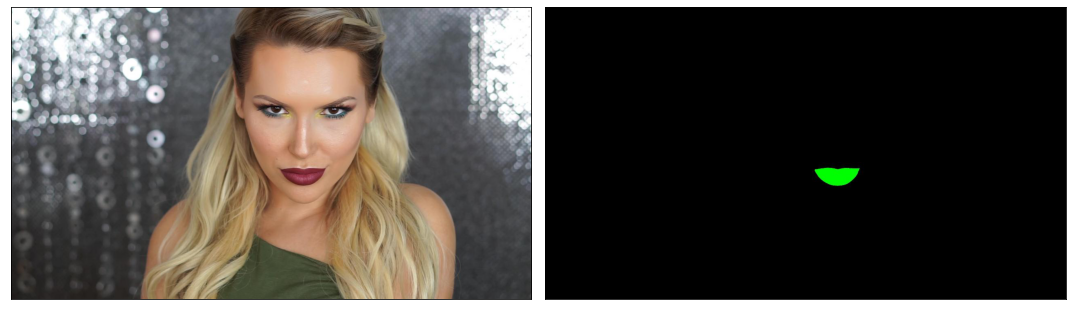

In [4]:
img = plt.imread(IMG_ROOT + 'image00000001.jpg')
msk = plt.imread(MSK_ROOT + 'mask00000001.png')
print(img.shape, msk.shape)

fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].imshow(img)
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(msk)
ax[1].set_xticks([])
ax[1].set_yticks([])

fig.tight_layout()
    
plt.show()

In [5]:
list_csv = pd.read_csv('../input/makeup-lips-segmentation-28k-samples/set-lipstick-original/list.csv')
list_csv.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


## Подготовка датасета

In [6]:
# сформируем списки с путями для изображений и масок из файла list_csv
df_paths = pd.DataFrame()
df_paths['img_path'] = [(IMG_ROOT + list_csv['filename'].loc[item]) for item in range(list_csv['filename'].shape[0])]
df_paths['msk_path'] = [(MSK_ROOT + list_csv['mask'].loc[item]) for item in range(list_csv['mask'].shape[0])]

print(df_paths.shape)

(28594, 2)


In [7]:
df_paths.head()

,img_path,msk_path
0,../input/makeup-lips-segmentation-28k-samples/...,../input/makeup-lips-segmentation-28k-samples/...
1,../input/makeup-lips-segmentation-28k-samples/...,../input/makeup-lips-segmentation-28k-samples/...
2,../input/makeup-lips-segmentation-28k-samples/...,../input/makeup-lips-segmentation-28k-samples/...
3,../input/makeup-lips-segmentation-28k-samples/...,../input/makeup-lips-segmentation-28k-samples/...
4,../input/makeup-lips-segmentation-28k-samples/...,../input/makeup-lips-segmentation-28k-samples/...


In [8]:
%%time
# сформируем списки с путями для изображений и масок из фактического наличия файлов в папках

DATA_ROOT = '../input/makeup-lips-segmentation-28k-samples/set-lipstick-original/'

img_list = []
msk_list = []

for root, dirs, files in os.walk(DATA_ROOT):
    for name in files:
        f = os.path.join(root, name)
        if '720p' in f:
            img_list.append(f)
        elif 'mask' in f:
            msk_list.append(f)
        else:
            break

CPU times: user 592 ms, sys: 759 ms, total: 1.35 s
Wall time: 48.5 s


In [9]:
# сравним списки и удалим строки, в которых отсутствуют данные

for item in range(df_paths.shape[0]):
    if df_paths.iloc[:, 0][item] not in img_list:
        df_paths.drop(item, inplace=True)
    elif df_paths.iloc[:, 1][item] not in msk_list:
        df_paths.drop(item, inplace=True)

print(df_paths.shape)

(28540, 2)


In [10]:
# cоздадим класс для кастомного датасета

class SelfDrivingDataset(Dataset):
    def __init__(self, data, preprocessing=None):
        
        self.data = data        
        self.image_arr = self.data.iloc[:, 0]
        self.label_arr = self.data.iloc[:, 1]
        
        # количество пар картинка-маска
        self.data_len = len(self.data.index)        
        self.preprocessing = preprocessing

        
    def __getitem__(self, index):
        
        # обрежем картинку и переводим ее в numpy-массив
        img = cv2.cvtColor(cv2.imread(self.image_arr[index]), cv2.COLOR_BGR2RGB)        
        img = cv2.resize(img, (256, 256))
        img = np.asarray(img).astype('float')        
        
        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        else:
            # нормализуем изображение в значениях [0, 1]
            img = torch.as_tensor(img) / 255.0
        img = img.permute(2, 0, 1)        
        
       # подготовим маску
        msk = cv2.cvtColor(cv2.imread(self.label_arr[index]), cv2.COLOR_BGR2RGB)
        msk = cv2.resize(msk, (256, 256))
        msk = np.asarray(msk).astype('float')        
        msk = torch.as_tensor(msk) / 255.0
        msk = msk.permute(2, 0, 1) 
        
            
        return (img.float(), msk)

    def __len__(self):
        return self.data_len

torch.Size([3, 256, 256]) torch.Size([3, 256, 256])


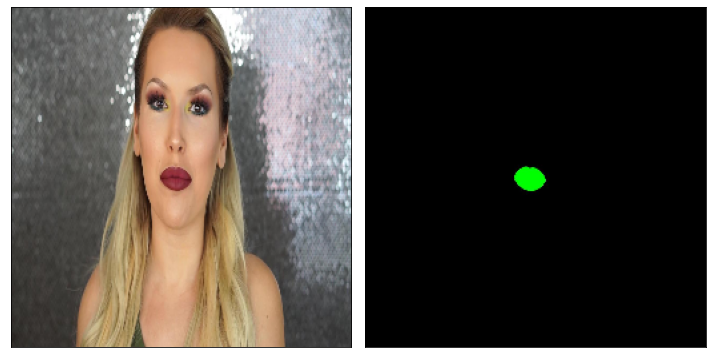

In [11]:
dataset = SelfDrivingDataset(df_paths)
img, msk = dataset[1]
print(img.shape, msk.shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 8))
ax[0].imshow(img.permute(1, 2, 0))
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(msk.permute(1, 2, 0))
ax[1].set_xticks([])
ax[1].set_yticks([])

fig.tight_layout()
    
plt.show()

In [12]:
# разделим на тренировочную выборку и тестовую
X_train, X_test = train_test_split(df_paths, test_size=0.3)

# упорядочим индексацию
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# обернем каждую выборку в кастомный датасет
train_data = SelfDrivingDataset(X_train)
test_data = SelfDrivingDataset(X_test)

In [13]:
# загрузим данные
train_data_loader = DataLoader(
    train_data,
    batch_size=32,
    shuffle=True,
    drop_last=True
)

test_data_loader = DataLoader(
    test_data,
    batch_size=32,
    shuffle=False
)

print(f'Length Train: {len(train_data_loader)}')
print(f'Length Test: {len(test_data_loader)}')

Length Train: 624
Length Test: 268


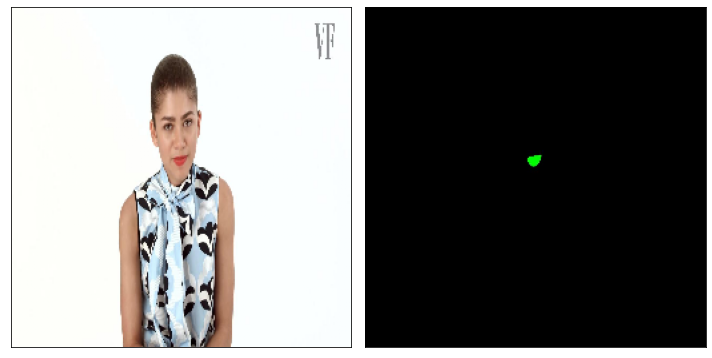

In [14]:
for img, target in train_data_loader:
    fig, ax = plt.subplots(1, 2, figsize=(10, 8))
    
    ax[0].imshow(img[0].permute(1, 2, 0))
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    
    ax[1].imshow(target[0].permute(1, 2, 0))
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    
    fig.tight_layout()
    
    break

## Создание и обучение модели

In [15]:
# создадим модель из модуля со встроенным энкодером
BACKBONE = 'resnet152'
segmodel = smp.Unet(BACKBONE, classes=1, activation='sigmoid').to(device)
preprocess_input = smp.encoders.get_preprocessing_fn(BACKBONE, pretrained='imagenet')

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [16]:
# зададим параметры

criterion = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(),]
optimizer = torch.optim.Adam(params=segmodel.parameters(), lr=0.001)

train_epoch = smp.utils.train.TrainEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [17]:
# обучим модель

max_score = 0

for i in range(0, 1):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_data_loader)
    valid_logs = valid_epoch.run(test_data_loader)    
    
    # можно модифицировать модель (сохранить модель, изменить lr и др.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(segmodel, './best_model.pth')
        print('Model saved!')

Epoch: 1
valid: 100%|██████████| 268/268 [05:36<00:00,  1.25s/it, dice_loss - 0.03196, iou_score - 0.9433]
Model saved!


## Проверка на тестовых данных

In [18]:
# достанем тестовые экземпляры
test_img, test_msk = next(iter(train_data_loader))
test_img_ = test_img.to(device)

# сделаем предсказания
predictions = segmodel.predict(test_img_)
predictions_ = (predictions.squeeze().cpu().numpy().round())

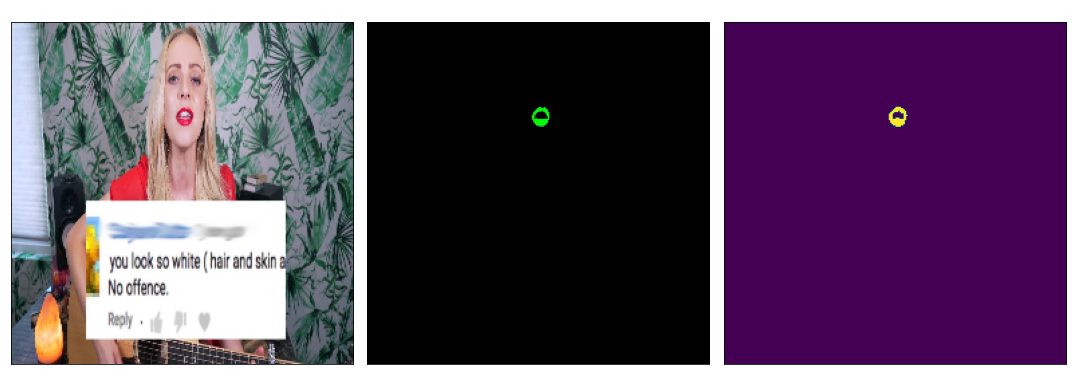

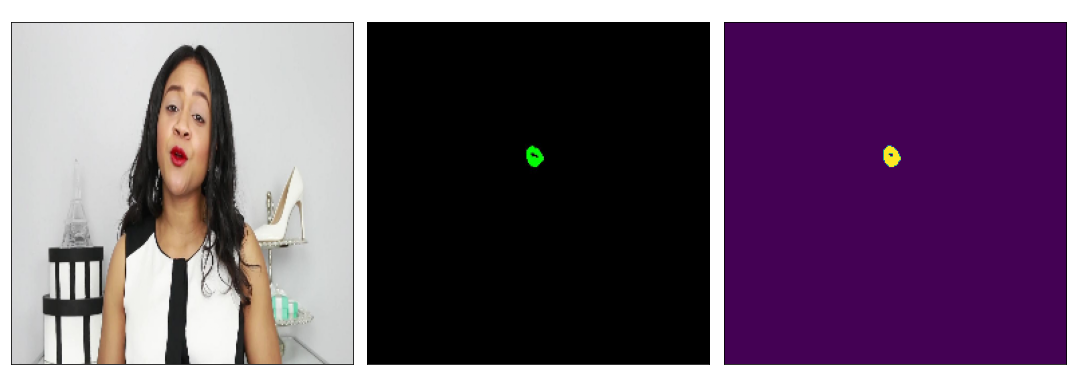

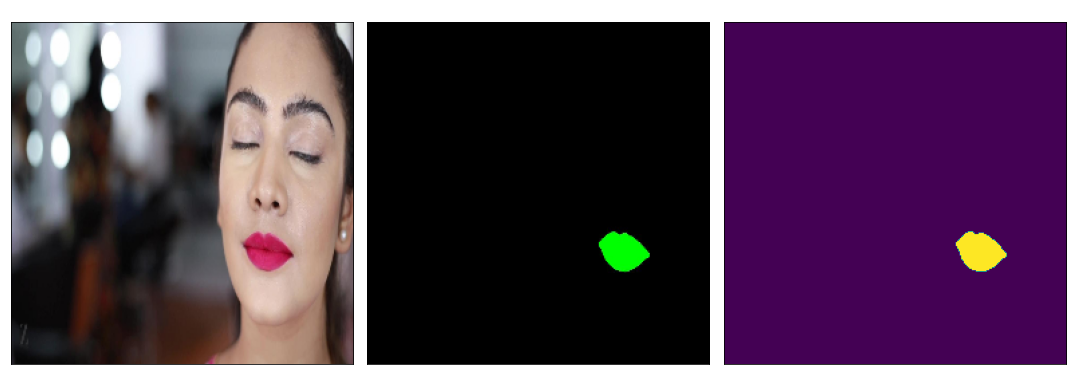

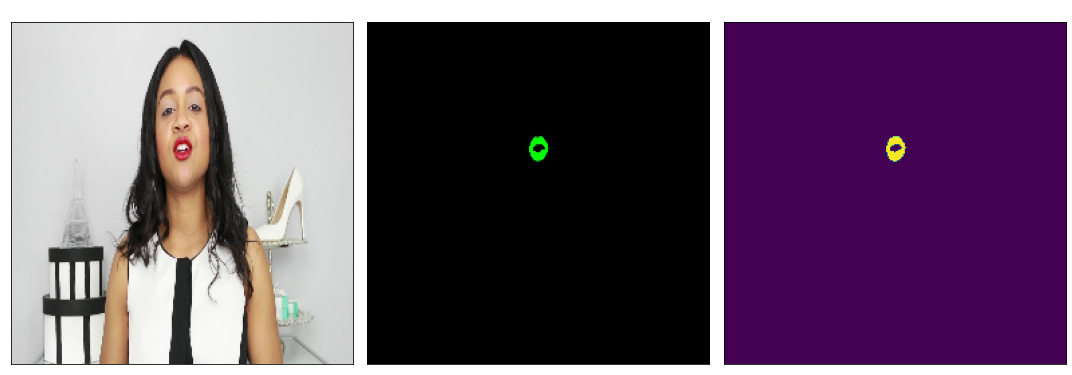

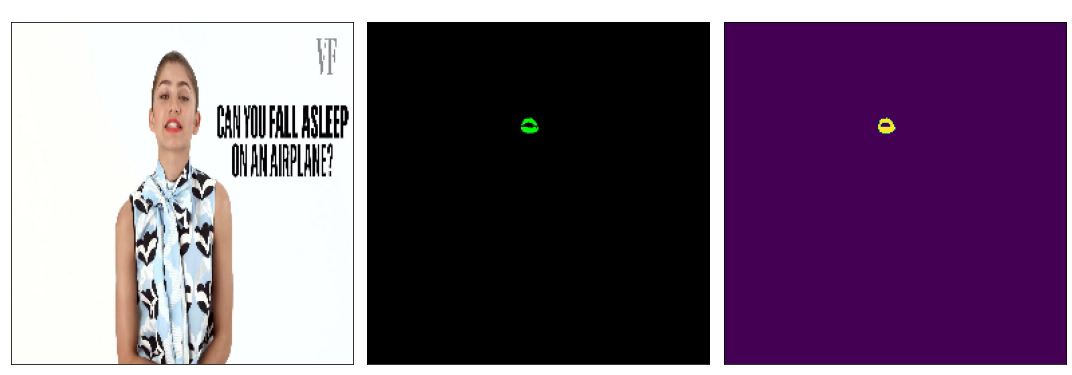

In [19]:
# визуализируем предсказания

for i in range(5):
    fig, ax = plt.subplots(1, 3, figsize=(15, 8))
    
    ax[0].imshow(test_img[i].permute(1, 2, 0))
    ax[0].set_title('Image', c='white')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    
    ax[1].imshow(test_msk[i].permute(1, 2, 0))
    ax[1].set_title('True mask', c='white')
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    
    ax[2].imshow(predictions_[i])
    ax[2].set_title('Predict mask', c='white')
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    
    fig.tight_layout()    

## Вывод

Модель Unet с энкодером 'resnet152' обучилась довольно хорошо. Метрика iou_score на тестовой выборке - **0.9414**.

## Проверка сохраненной модели

In [20]:
# загрузим модель
our_trained_model = torch.load('./best_model.pth')

# сделаем предсказания
new_predictions = our_trained_model.predict(test_img_)
new_predictionss_ = (new_predictions.squeeze().cpu().numpy().round())

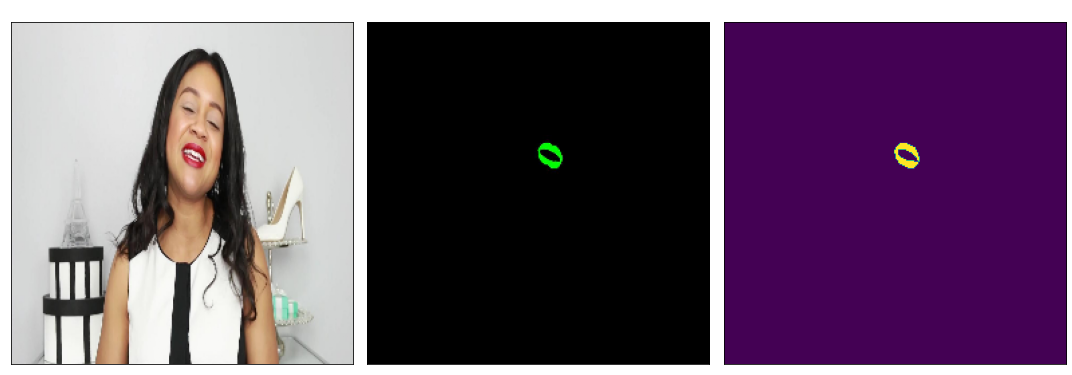

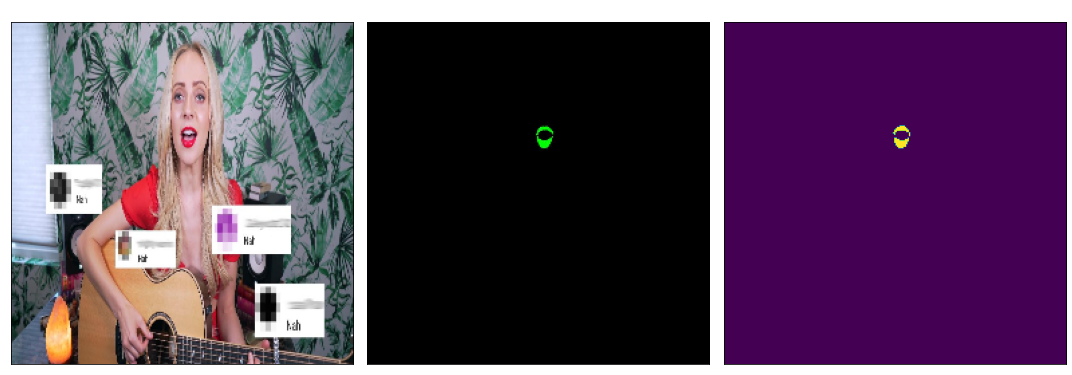

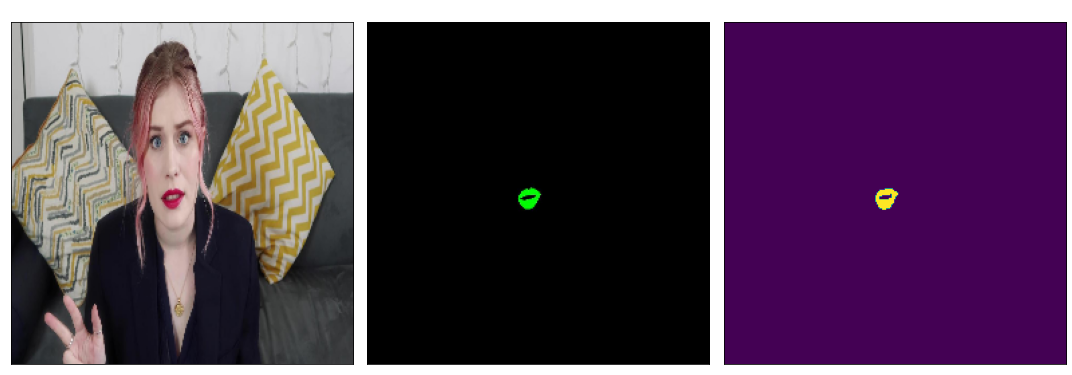

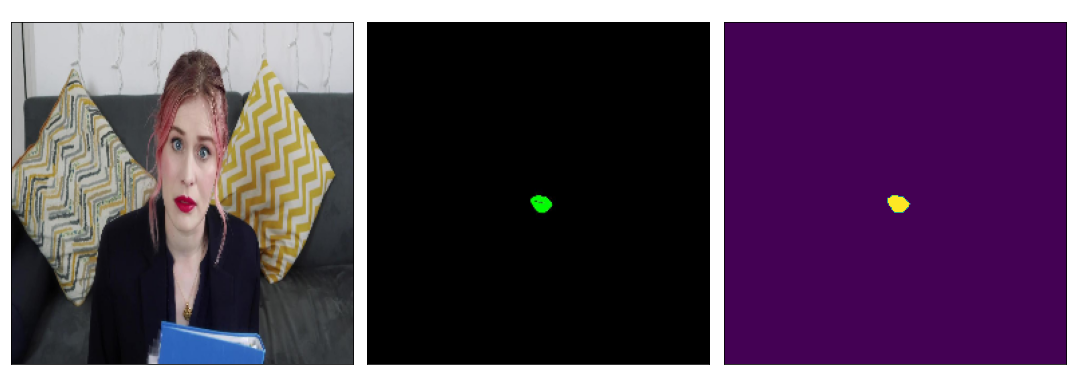

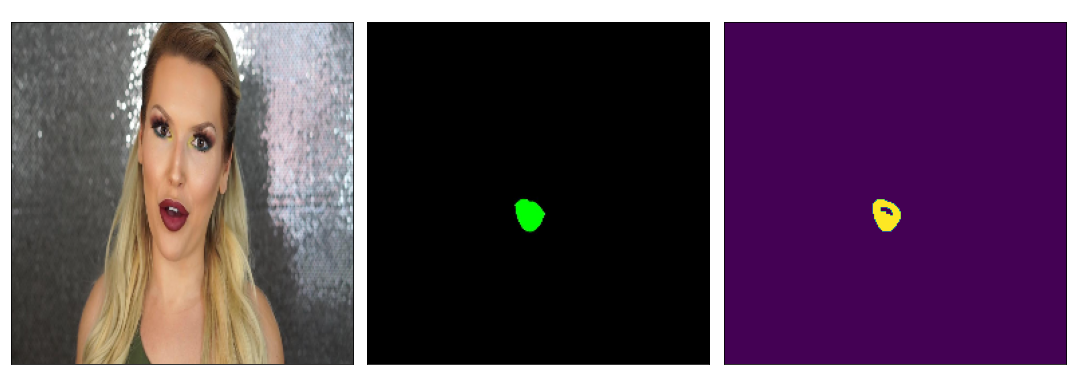

In [21]:
# визуализируем предсказания

for i in range(15, 20):
    fig, ax = plt.subplots(1, 3, figsize=(15, 8))
    
    ax[0].imshow(test_img[i].permute(1, 2, 0))
    ax[0].set_title('Image', c='white')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    
    ax[1].imshow(test_msk[i].permute(1, 2, 0))
    ax[1].set_title('True mask', c='white')
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    
    ax[2].imshow(new_predictionss_[i])
    ax[2].set_title('Predict mask', c='white')
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    
    fig.tight_layout()    